In [1]:
import psycopg2
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
'''
cdf.columns = ['Idx', 'OPD_RD', 'Date', 'Time', 'Lat', 'Lng', 'year', 'year_month', 'quality', 'nonviolent', 'car_break_in', 'car_theft', 'violent', 'geom', 'block_group']
#cdf['quarter'] = pd.DatetimeIndex(cdf.Date).quarter
cdf['day_of_week'] = pd.DatetimeIndex(cdf.Date).dayofweek
#cdf['week'] = pd.DatetimeIndex(cdf.Date).week
#cdf['month'] = pd.DatetimeIndex(cdf.Date).month
#cdf['day'] = pd.DatetimeIndex(cdf.Date).day
#cdf['day_of_year'] = pd.DatetimeIndex(cdf.Date).dayofyear
#cdf['week_of_year'] = pd.DatetimeIndex(cdf.Date).weekofyear
cdf['hour'] = [i.hour for i in cdf.Time]
#combine date and time column so I can plot over 'em
#cdf['Datetime'] = pd.to_datetime(cdf['Date'].astype(str) + ' ' + cdf['Time'].astype(str))
'''

In [24]:
conn = psycopg2.connect("dbname=oakland user=danaezoule")
cur = conn.cursor()
cur.execute("SELECT * FROM area_features;")
df = pd.DataFrame(cur.fetchall())
cdf = df.copy()
cdf.columns = ['Group_Block', 'Year', 'Quality', 'Nonviolent', 'Vehicle_Break_In', 'Vehicle_Theft', 'Violent']

In [30]:
# Splitting data by year, clustering by first year, predicting clusters for following years.
# Simple clustering model - first pass - on count on crimes in each category.
from sklearn.cluster import KMeans
km = KMeans()
columns = ['Quality', 'Nonviolent', 'Vehicle_Break_In', 'Vehicle_Theft', 'Violent']
clus = km.fit_predict(cdf[cdf.Year == 2009].sort('Group_Block')[columns])
clus10 = km.predict(cdf[cdf.Year == 2010].sort('Group_Block')[columns])
clus11 = km.predict(cdf[cdf.Year == 2011].sort('Group_Block')[columns])

In [ ]:
'''Feature Engineering Brainstorming:
Normalization:
    #Normalize by population: none, assume census divisions cover this
    #Normalize by geography (square footage or meterage) -no, don't want to double norm
    #Normalize by total crime count -see next point
    Normalize beach column by mean/stdev

#Geographical:
#    Census tracts, group blocks, or blocks
#        Group blocks

#Time Group By:
#    Month, quarter, year
#        year

Time features:
     #Day of week
@    Count for weekday or weekend
@    Count for time of day (morning, afternoon, eve, night)
        Split by data. First hypothesis:
@        Morning: 6am-noon
@        Afternoon: noon-6pm
@        Eve: 6pm-midnight
@        Early: midnight-6am
    
#Housing etc:
#    Are Trulia neighborhoods census tracts? Can I get block group info from Trulia?
#    Will the ACS be helpful? Can I get yearly or quarterly ACS information?
    
#Time component:
#    Create centroids from earliest data, map all points to same centroids
    Create new centroids for each year (with varied data) as below 
    
Data that varies from year to year:
    If I use it, can I detect similar centroids between years?
    Should I instead ignore this completely, despite losing rental data?
'''

In [261]:
conn = psycopg2.connect("dbname=oakland user=danaezoule")
cur = conn.cursor()
cur.execute("SELECT * FROM crime_blocks;")
df = pd.DataFrame(cur.fetchall())
cdf = df.copy()
cdf.columns = cdf.columns = ['Idx', 'OPD_RD', 'Date', 'Time', 'Lat', 'Lng', 'year', 'year_month', 'quality', 'nonviolent', 'car_break_in', 'car_theft', 'violent', 'geom', 'group_block']
cdf['day_of_week'] = pd.DatetimeIndex(cdf.Date).dayofweek
cdf['hour'] = [i.hour for i in cdf.Time]
cdf['weekend'] = cdf.day_of_week.isin([5,6])*1
cdf['morning'] = cdf.hour.isin([1, 2, 3, 4, 5, 6, 7])*1
cdf['workday'] = cdf.hour.isin([8, 9, 10, 11, 12, 13, 14, 15])*1
cdf['evening'] = cdf.hour.isin([16, 17, 18, 19, 20, 21, 22, 23])*1

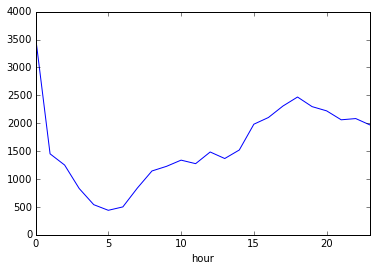

In [140]:
# Quality crimes have low from 2am-7am, peak at 6pm
cdf.groupby('hour').quality.sum().plot()

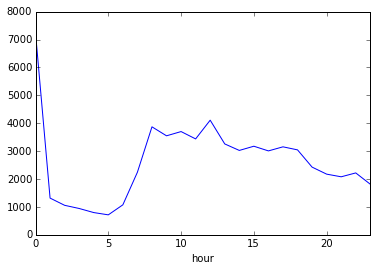

In [63]:
# Nonviolent crimes have low from 1am - 6am
cdf.groupby('hour').nonviolent.sum().plot()

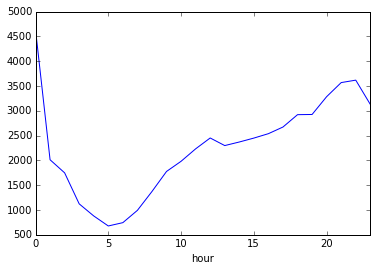

In [59]:
# Violent crimes have low from 2am - 8am, peak at 10/11pm
cdf.groupby('hour').violent.sum().plot()

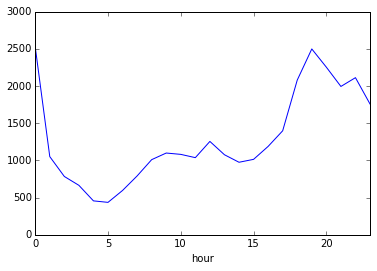

In [61]:
# Car break ins are low from 2am - 7am, peak 7pmish (dinner?)
cdf.groupby('hour').car_break_in.sum().plot()

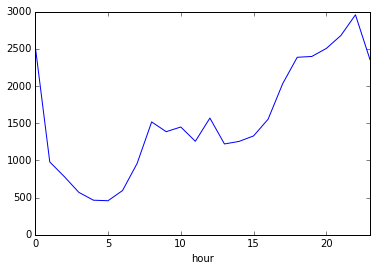

In [62]:
# Car thefts have low 2am - 7am, peak late 10pm/11pm
cdf.groupby('hour').car_theft.sum().plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d9af390>]], dtype=object)

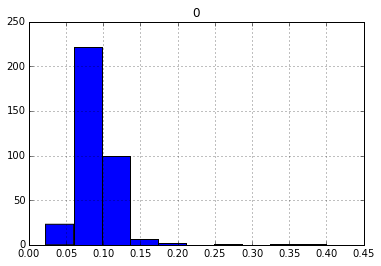

In [144]:
# From this I conclude that use of the 0 label is similar across neighborhoods.
# I will drop it out of engineered time features!
hour_zero = cdf[cdf.hour == 0].groupby('group_block')[['quality', 'nonviolent', 'car_break_in', 'car_theft', 'violent']].sum().sum(axis=1)
all_hrs = cdf.groupby('group_block')[['quality', 'nonviolent', 'car_break_in', 'car_theft', 'violent']].sum().sum(axis=1)
newdf = pd.DataFrame(hour_zero) / pd.DataFrame(all_hrs[all_hrs > 4])
newdf.hist()

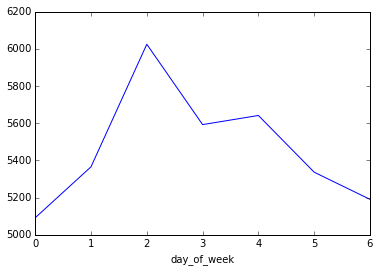

In [242]:
cdf.groupby('day_of_week').quality.sum().plot()

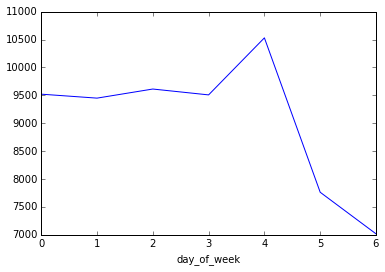

In [243]:
cdf.groupby('day_of_week').nonviolent.sum().plot()

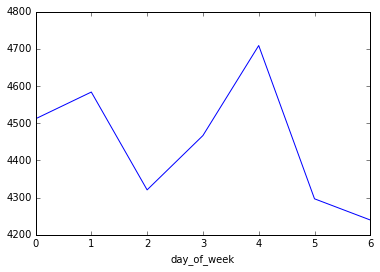

In [244]:
cdf.groupby('day_of_week').car_break_in.sum().plot()

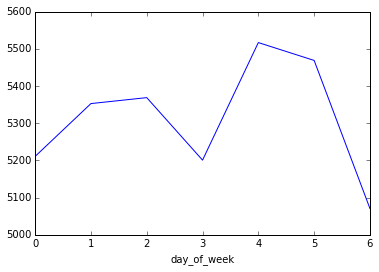

In [245]:
cdf.groupby('day_of_week').car_theft.sum().plot()

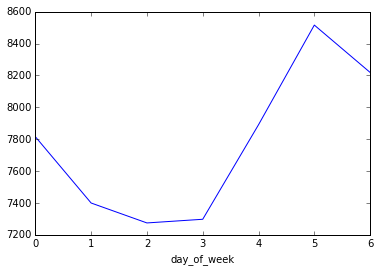

In [246]:
cdf.groupby('day_of_week').violent.sum().plot()

In [191]:
tdf = pd.get_dummies(cdf, prefix='hr', columns=['hour'])
tdf = pd.get_dummies(tdf, prefix='dow', columns=['day_of_week'])
tdf.drop(['Idx','Lat','Lng','year_month'], axis=1, inplace=True)

In [198]:
# look for outliers with respect to hour, day of week... preferably on a map, with hoverover
# lat/long outliers are controlled for by only selecting areas with crime counts with min 1/year

In [225]:
# Exclude group blocks that don't have at least one crime count per year
tmp = tdf.groupby(['group_block']).year.nunique()
good_gbs = [i for i, v in tmp.iteritems() if v>=6]
ndf = tdf[tdf.group_block.isin(good_gbs)]

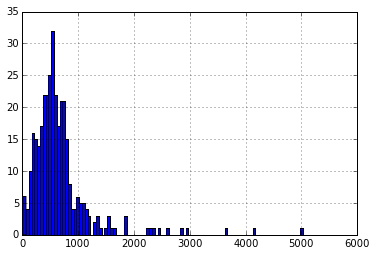

In [236]:
# Would like to see histogram of total crime counts over neighborhoods to find outliers
ndf.groupby('group_block')[['violent', 'nonviolent', 'quality', 'car_break_in', 'car_theft']].sum().sum(axis=1).hist(bins=100)

In [ ]:
# get outliers
# put outliers on a map
# keep them in analysis?
# these outliers ARE VERY OUTLIERY!
# or are they?
# boxplot
# OR: IGNORE AND PCA ALREADY. PLZ
# DBSCAN can take care of them!

In [237]:
ndf.columns

Index([u'OPD_RD', u'Date', u'Time', u'year', u'quality', u'nonviolent',
       u'car_break_in', u'car_theft', u'violent', u'geom', u'group_block',
       u'weekend', u'morning', u'workday', u'evening', u'hr_0', u'hr_1',
       u'hr_2', u'hr_3', u'hr_4', u'hr_5', u'hr_6', u'hr_7', u'hr_8', u'hr_9',
       u'hr_10', u'hr_11', u'hr_12', u'hr_13', u'hr_14', u'hr_15', u'hr_16',
       u'hr_17', u'hr_18', u'hr_19', u'hr_20', u'hr_21', u'hr_22', u'hr_23',
       u'dow_0', u'dow_1', u'dow_2', u'dow_3', u'dow_4', u'dow_5', u'dow_6'],
      dtype='object')

In [247]:
pca_df = pd.DataFrame()

In [249]:
pca_df['group_block']

""


In [250]:
ndf.head()

,OPD_RD,Date,Time,year,quality,nonviolent,car_break_in,car_theft,violent,geom,...,hr_21,hr_22,hr_23,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,01-015068,2010-02-24,00:00:00,2010,0,1,0,0,0,0101000020E6100000B41EBE4C14925EC0CE6E2D93E1E6...,...,0,0,0,0,0,1,0,0,0,0
1,01-666666,2009-06-23,00:00:00,2009,0,0,0,0,1,0101000020E61000001C9947FE608D5EC0FC1BB4571FE7...,...,0,0,0,0,1,0,0,0,0,0
2,06-000000,2009-07-02,00:00:00,2009,1,0,0,0,0,0101000020E6100000696FF085C9915EC09605137F14E7...,...,0,0,0,0,0,0,1,0,0,0
3,07-037438,2010-05-11,19:59:00,2010,0,0,1,0,0,0101000020E61000007E7214200A8C5EC09259BDC3EDE0...,...,0,0,0,0,1,0,0,0,0,0
4,08-010193,2015-01-04,14:30:00,2015,0,1,0,0,0,0101000020E610000005BF0D315E905EC03CC1FEEBDCE8...,...,0,0,0,0,0,0,0,0,0,1


In [259]:
type(cdf.weekend.head(1)[0])

numpy.bool_

In [260]:
cdf.weekend*1

0         0
1         0
2         0
3         0
4         1
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
224362    0
224363    0
224364    0
224365    0
224366    0
224367    0
224368    0
224369    0
224370    0
224371    0
224372    0
224373    1
224374    0
224375    0
224376    0
224377    0
224378    0
224379    0
224380    0
224381    0
224382    0
224383    0
224384    1
224385    0
224386    0
224387    1
224388    0
224389    0
224390    0
224391    0
Name: weekend, dtype: int64